### How Multi AI Agents work together to solve complex workflows
- Different techniques, simple multi AI agents, supervisor multi AI agents architecture, hierarchical multi AI agents architectures
- This is a crash course on how to build Multi AI Agent to solve complex workflow. Some topics will not be covered in details.
- Simple Multi AI Agents
    - Information flows from one agent to another
    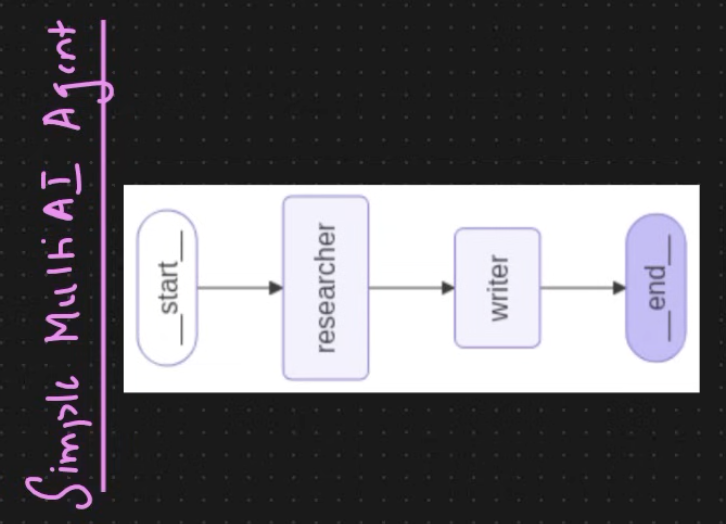

- Supervisor AI Agents
    - There will be a supervisor role, responsible for assigning tasks to other AI Agents (e.g. Analyst, Researcher, or Writer, etc.). 
    - Once the task is done by the assigned Agent, the work will be assigned back to supervisor where supervisor will decide next step or end the workflow.
    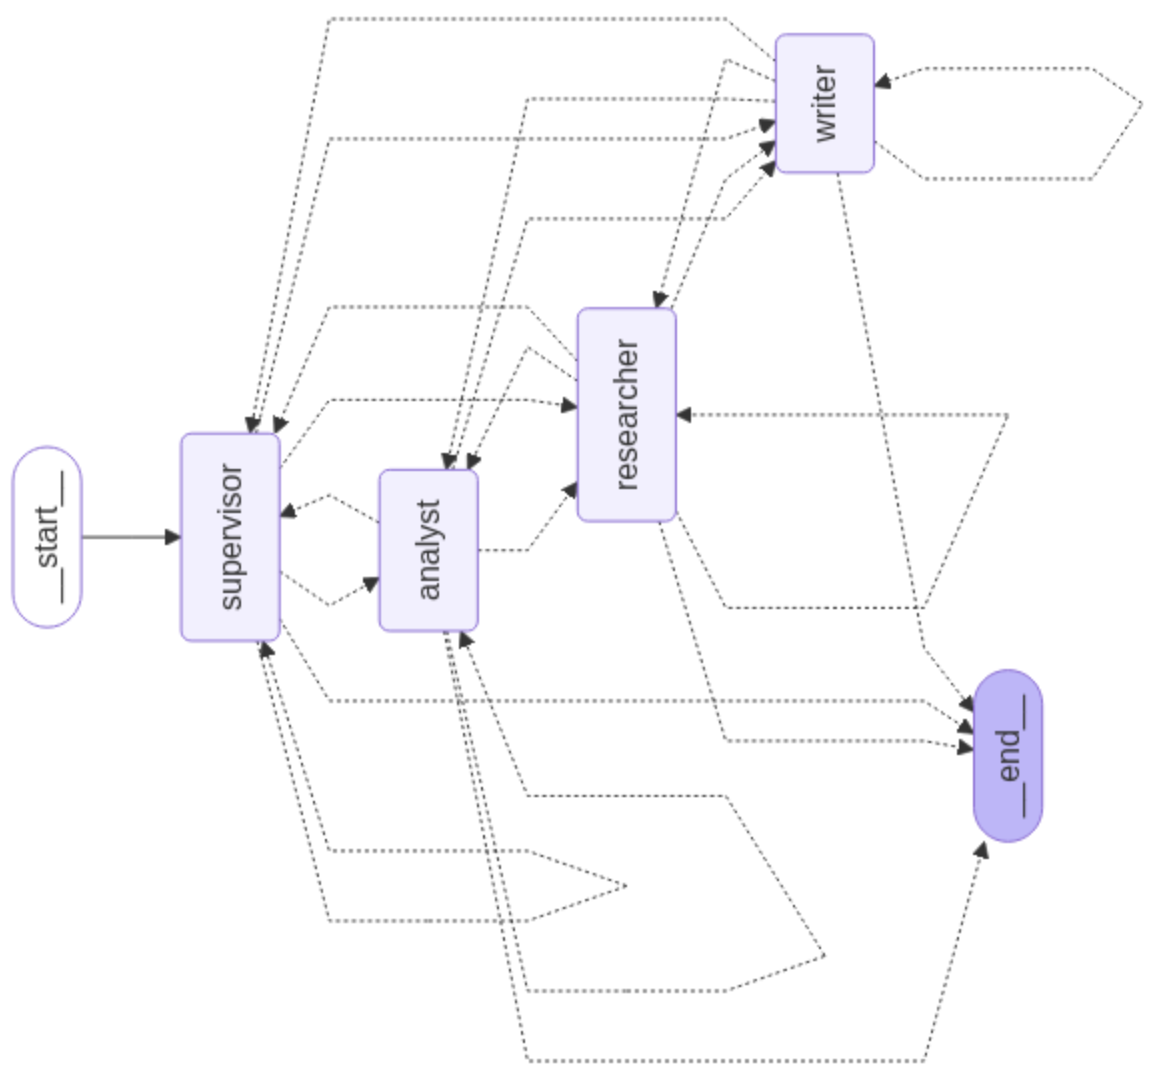

- Hierarchical AI Agents
    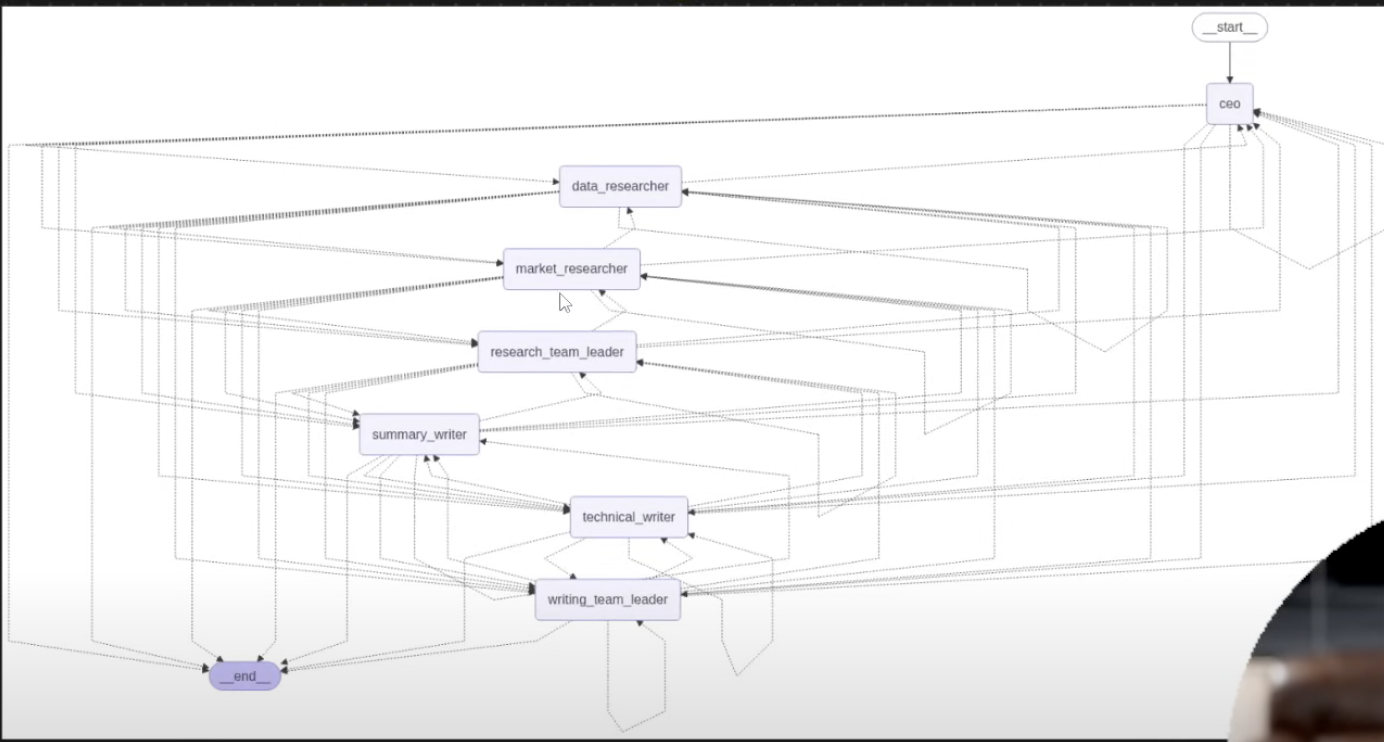
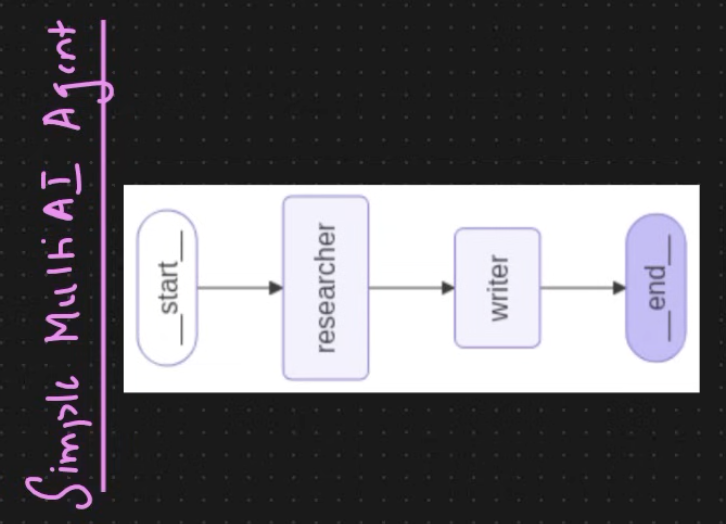
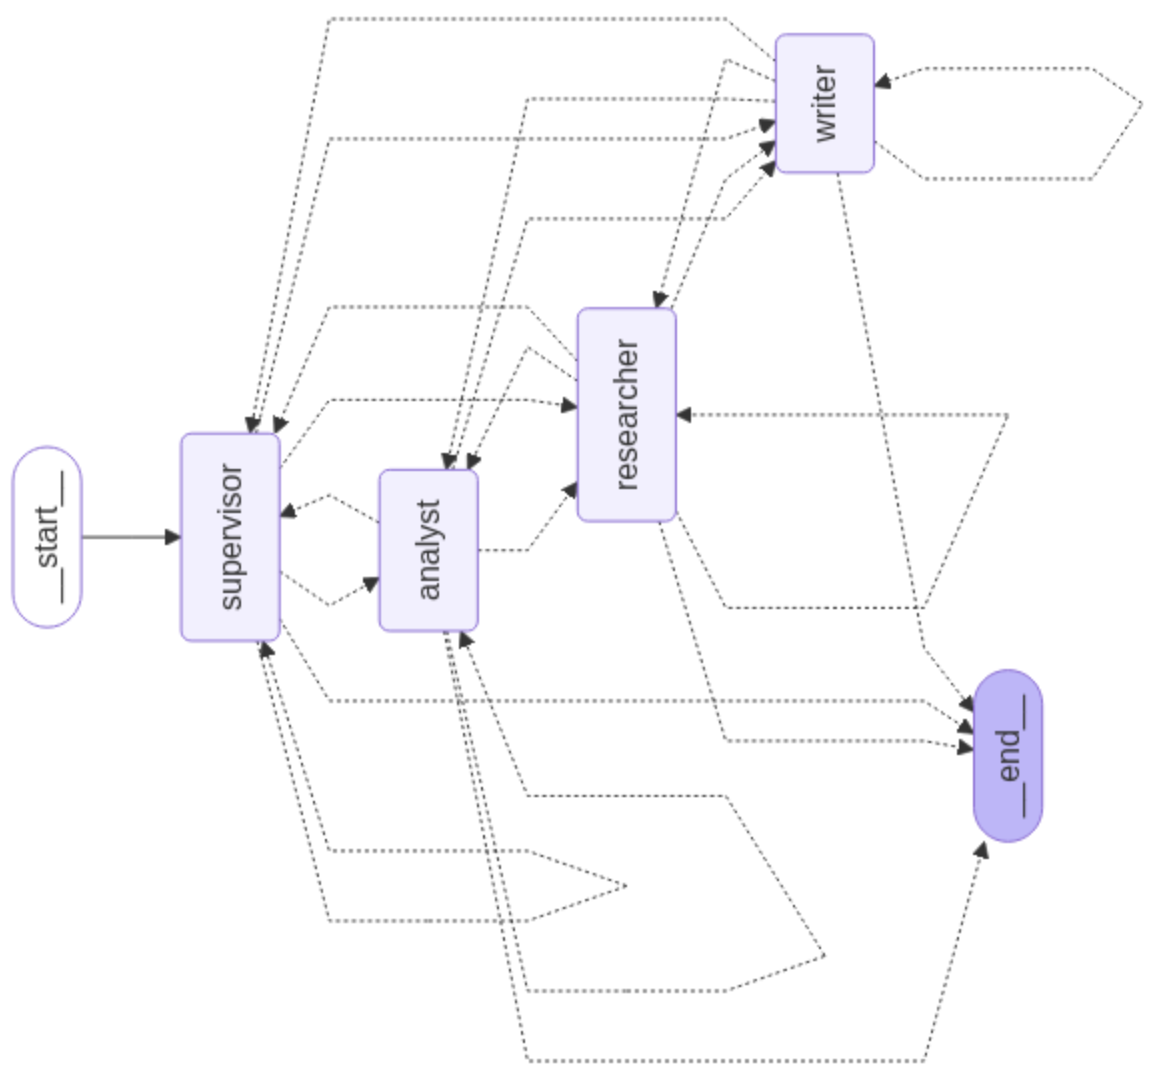
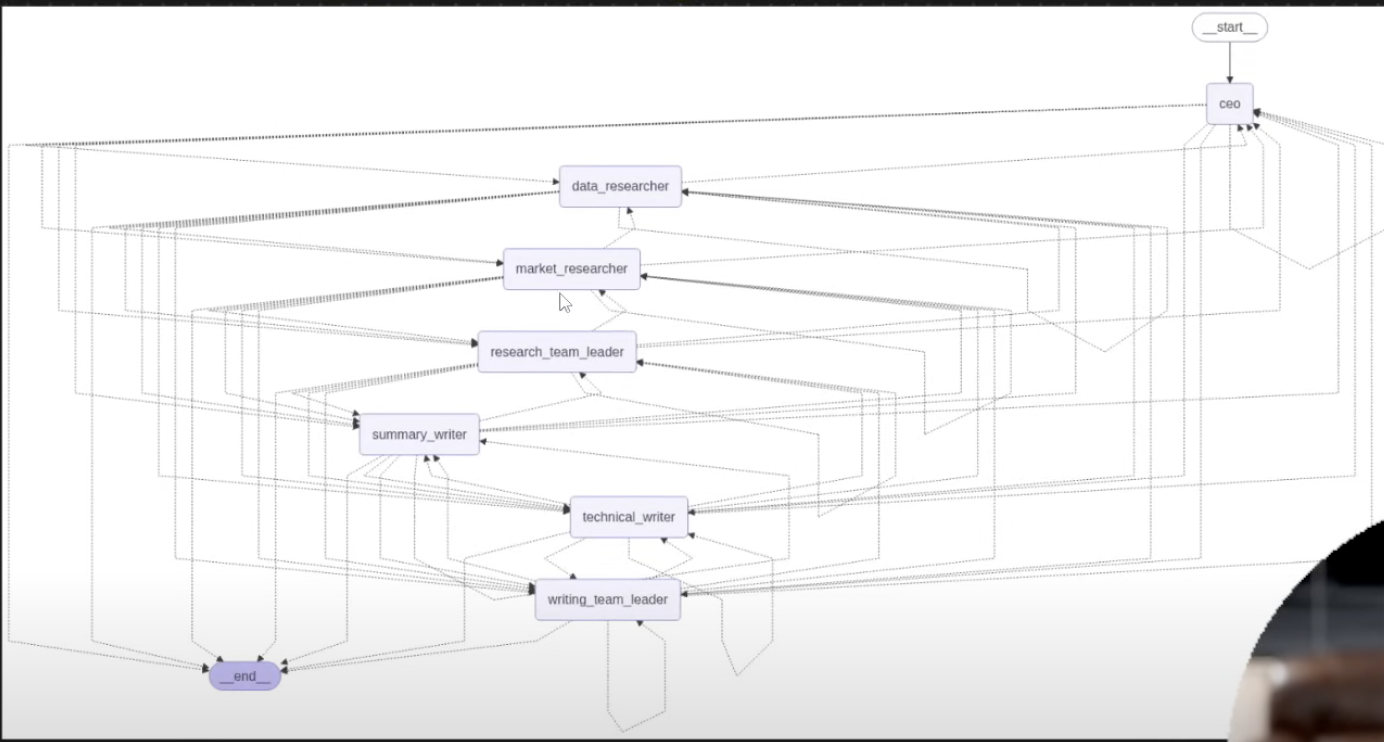

In [1]:
import os
import random
from datetime import datetime
from typing import TypedDict, Annotated, List, Dict, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

### Simple Multi AI Agent
- Researcher: Does web search to research on given topic
- Writer: Writes summary of what he is provided.

In [3]:
### Define the AgentState
class AgentState(MessagesState):
    next_agent:str  ### Which Agent should go next

In [4]:
### Create sample tool
@tool
def search_web(query: str) -> str:
    """
    Search web for information
    """
    search = TavilySearchResults(max_results=3)
    results = search.invoke(query)
    return str(results)

@tool
def write_summary(content: str) -> str:
    """
    Write a summary of the provided content
    """
    summary = 'Summary of findings: \n\n{}...'.format(content[:500])
    return summary

In [13]:
llm = init_chat_model('groq:llama3-8b-8192')
# llm = init_chat_model('ollama:llama3.2:1b')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10c8ff230>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10c8ffe00>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [14]:
llm.invoke('Hi')

AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.034542435, 'prompt_time': 0.008016354, 'queue_time': 1.080534052, 'total_time': 0.042558789}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_346a0f709e', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ce3522b9-a683-44f8-8ad8-46bdfe8e47b9-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})

In [15]:
### Define research agent function (simpler approach)
def researcher_agent(state: AgentState):
    """
    Researcher Agent that searches for information.
    """
    messages = state['messages']

    ### Add system message for context
    system_message = SystemMessage(content='You are a research assistant. Use the search_web tool to find information about the user"s request.')

    ### Call LLM with tools
    researcher_tools = [search_web]
    researcher_llm = llm.bind_tools(researcher_tools)
    response = researcher_llm.invoke([system_message] + messages)

    ### Return the response and route to writer
    return {'messages': [response], 'next_agent': 'writer'}

In [16]:
### Define writer agent function (simpler approach)
def writer_agent(state: AgentState):
    """
    Writer Agent that creates summaries
    """
    messages = state['messages']

    ### Add system message for context
    system_message = SystemMessage(content='You are a technical writer. Review the conversation and create a clear, concise summary of the findings.')

    # ### Simple completion with tools
    # writer_tools = [write_summary]
    # writer_llm = llm.bind_tools[writer_tools]
    # response = writer_llm.invoke([system_message] + messages)

    ### Simple completion without tools
    response = llm.invoke([system_message] + messages)

    ### Return the response and route to end state
    return {'messages': [response], 'next_agent': 'end'}

In [17]:
### Create Tool Executor Node
def execute_tools(state: AgentState):
    """
    Execute any pending tool calls
    """
    messages = state['messages']
    last_message = messages[-1]

    ### Check if there are tool calls to execute
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        ### Create tool node and execute
        tool_node = ToolNode([search_web, write_summary])
        response = tool_node.invoke(state)
        return response
    
    ### If no tool call to execute
    return state

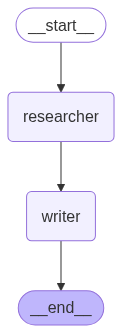

In [18]:
### Build graph 
workflow = StateGraph(MessagesState)

### Add Nodes
workflow.add_node('researcher', researcher_agent)
workflow.add_node('writer', writer_agent)

### Define flow
workflow.set_entry_point('researcher')
workflow.add_edge('researcher', 'writer')
workflow.add_edge('writer', END)

final_workflow = workflow.compile()
final_workflow

In [21]:
response = final_workflow.invoke({'messages': 'Research about the use case of Agentic AI in business'})

In [22]:
response['messages'][-1].content

'\n\nAfter researching the topic, the following findings were discovered:\n\n**Overview**\n\nAgentic AI refers to a type of artificial intelligence (AI) that enables machines to take actions on behalf of humans, mimicking human agency. In the context of business, Agentic AI can be used to automate decision-making processes, streamline workflows, and improve overall efficiency.\n\n**Key Findings**\n\n1. **Automation of Routine Tasks**: Agentic AI can automate repetitive and mundane tasks, freeing up human resources to focus on higher-value tasks that require creativity and judgment.\n2. **Predictive Maintenance**: Agentic AI can be used to predict equipment failures and schedule maintenance activities, reducing downtime and increasing overall equipment effectiveness.\n3. **Process Optimization**: Agentic AI can analyze business processes and identify areas for improvement, allowing businesses to optimize their operations and reduce costs.\n4. **Customer Service**: Agentic AI can be used

#### Observations:
- Notice the flow is always from researcher to writer and to end state.
- Is there a way for writer to loop back to researcher for finetuning? We can use conditional_edges but it may not always work well.
- Using conditional_edges in this use case, we cannot develop an efficient system.
- Answer: `Supervisor Multi AI Agent`

### Supervisor Multi AI Agent
- Create a supervisor node that will have the control to decide which node to go to.
- E.g. 'Write me an article on Agentic AI'. 
    - Supervisor assign to researcher then to writer.
    - If there is a report given, Supervisor could assign to an analyst before writer.
- This is more efficient than Simple Multi AI Agent.

In [57]:
### Define SupervisorState
class SupervisorState(MessagesState):
    """
    State for the supervisor Multi AI Agent system
    """
    next_agent: str = ''
    research_data: str = ''
    analysis: str = ''
    final_report: str = ''
    task_complete: bool = False
    current_task: str = ''

In [86]:
### Create Supervisor Chain
def create_supervisor_chain():
    """
    Creates the supervisor decision chain
    """
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
        1. Researcher - Gathers information and data
        2. Analyst - Analyzes data and provides insights  
        3. Writer - Creates reports and summaries

        Based on the current state and conversation, decide which agent should work next.
        If the task is complete, respond with 'DONE'.

        Current state:
        - Has research data: {has_research}
        - Has analysis: {has_analysis}
        - Has report: {has_report}

        Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
        """),
        ("human", "{task}")
    ])

    return supervisor_prompt | llm

In [87]:
### Define Supervisor Node
def supervisor_agent(state: SupervisorState) -> Dict:
    """
    Supervisor decides next agent using LLM
    """
    
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    
    ### Check what's been completed
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))
    
    ### Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })
    
    ### Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)
    
    ### Determine next agent
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "Supervisor: All tasks complete! Great work team."
    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "Supervisor: Let's start with research. Assigning to Researcher..."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "Supervisor: Research done. Time for analysis. Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."
    else:
        next_agent = "end"
        supervisor_msg = "Supervisor: Task seems complete."
    
    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [88]:
### Define Research Agent
def researcher_agent(state: SupervisorState) -> Dict:
    """
    Researcher uses Groq to gather information
    """
    
    task = state.get("current_task", "research topic")
    
    ### Create research prompt
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""
    
    ### Get research from LLM
    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content
    
    ### Create agent message
    agent_message = f"Researcher: I've completed the research on '{task}'.\n\nKey findings:\n{research_data[:500]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent": "supervisor"
    }

In [89]:
### Define Analyst Agent
def analyst_agent(state: SupervisorState) -> Dict:
    """
    Analyst uses Groq to analyze the research
    """
    
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")
    
    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

    Research Data:
    {research_data}

    Provide:
    1. Key insights and patterns
    2. Strategic implications
    3. Risks and opportunities
    4. Recommendations

    Focus on actionable insights related to: {task}"""
    
    # Get analysis from LLM
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content
    
    # Create agent message
    agent_message = f"Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }

In [90]:
### Define Writer Agent
def writer_agent(state: SupervisorState) -> Dict:
    """
    Writer uses LLM to create final report
    """
    
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

    Task: {task}

    Research Findings:
    {research_data[:1000]}

    Analysis:
    {analysis[:1000]}

    Create a well-structured report with:
    1. Executive Summary
    2. Key Findings  
    3. Analysis & Insights
    4. Recommendations
    5. Conclusion

    Keep it professional and concise."""
        
    # Get report from LLM
    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = report_response.content
    
    # Create final formatted report
    final_report = f"""
    FINAL REPORT
    {'='*50}
    Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
    Topic: {task}
    {'='*50}

    {report}

    {'='*50}
    Report compiled by Multi-Agent AI System powered by LLM"""
    
    return {
        "messages": [AIMessage(content=f"✍️ Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [91]:
### Define Router 
def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """
    Routes to next agent based on state
    """
    
    next_agent = state.get("next_agent", "supervisor")
    
    if next_agent == "end" or state.get("task_complete", False):
        return END
        
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
        
    return "supervisor"

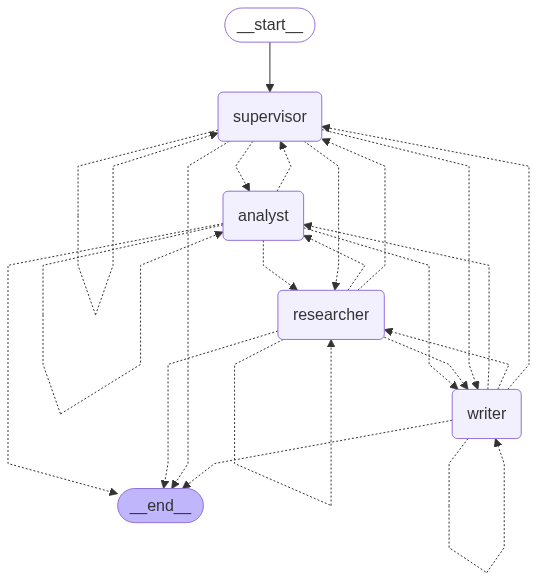

In [92]:
### Create workflow
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

# Add routing
for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )

graph=workflow.compile()
graph

In [93]:
# response = graph.invoke(HumanMessage(content='What are the benefits and risks of AI in healthcare?'))
response = graph.invoke({'messages': [HumanMessage(content='What are the benefits and risks of AI in healthcare?')]})

researcher
analyst
writer


In [95]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What are the benefits and risks of AI in healthcare?
================================== Ai Message ==================================

Supervisor: Let's start with research. Assigning to Researcher...
================================== Ai Message ==================================

Researcher: I've completed the research on 'What are the benefits and risks of AI in healthcare?'.

Key findings:
**Key Facts and Background:**

Artificial Intelligence (AI) in healthcare refers to the application of AI and machine learning algorithms to medical data, electronic health records (EHRs), and medical imaging to improve patient outcomes, reduce costs, and enhance healthcare delivery. AI in healthcare has the potential to revolutionize the industry by providing personalized medicine, early disease detection, and optimized treatment plans.

**Current Trends or Developments:**

1. **Expanding appli...
=================

### Hierarchical Multi AI Agent
- Structure:
    - CEO (top level)
        - Research Team Leader
            - Data Researcher
            - Market Researcher
        - Writing Team Leader
            - Technical Writer
            - Summary Writer